In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data

In [2]:
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, generate_training_data

print("Regenerating Training Features from Raw Data (Snapshot Approach)...")
train_raw_path = '../data/train.parquet'
train_df_raw = pd.read_parquet(train_raw_path)
train_df_raw = extract_user_attributes(train_df_raw)

# --- SMART DATA GENERATION ---
# We use the strategy that gave us the All-Time High (0.648).
# - Churners: Snapshots at 1, 3, 7 days before churn.
# - Non-Churners: Random active snapshots + "Dormancy" snapshots (after last event).
# This aligns the training distribution with the test set (where many users are dormant).

df = generate_training_data(train_df_raw)

print(f"Dataset Shape: {df.shape}")
print(f"Churn Rate: {df['target'].mean():.2%}")

print("\nAvg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):")
print(df[df['target']==0]['days_since_last_session'].describe())

df.head()

Regenerating Training Features from Raw Data (Snapshot Approach)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Dataset Shape: (85807, 65)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64
Dataset Shape: (85807, 65)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64


,userId,cutoff_ts,gender,level,platform,is_thumbs_up,is_thumbs_down,is_ad,is_error,is_song,length,downgrade,songs_last_1d,errors_last_1d,thumbs_down_last_1d,listen_time_last_1d,unique_artists_last_1d,unique_songs_last_1d,songs_last_3d,errors_last_3d,thumbs_down_last_3d,listen_time_last_3d,unique_artists_last_3d,unique_songs_last_3d,songs_last_7d,errors_last_7d,thumbs_down_last_7d,listen_time_last_7d,unique_artists_last_7d,unique_songs_last_7d,songs_last_14d,errors_last_14d,thumbs_down_last_14d,listen_time_last_14d,unique_artists_last_14d,unique_songs_last_14d,songs_last_30d,errors_last_30d,thumbs_down_last_30d,listen_time_last_30d,unique_artists_last_30d,unique_songs_last_30d,account_lifetime,avg_songs_per_day,thumbs_ratio,errors_per_song,trend_songs_7d_vs_30d,trend_listen_time_7d_vs_30d,total_sessions,avg_days_between_sessions,days_since_last_session,avg_songs_per_session,avg_session_duration,last_session_errors,last_session_songs,last_session_length,last_session_downgrade,activity_trend,boredom_ratio,exploration_ratio,hate_ratio_7d,recency_frequency_ratio,session_velocity,state_freq,target
0,1000025,2018-10-11 20:33:05,M,paid,Windows,69,10,4,0,975,243551.84526,0,69.0,0.0,0.0,18710.06828,68.0,69.0,237.0,0.0,0.0,60354.32190,218.0,231.0,362.0,0.0,2.0,91829.20396,326.0,345.0,975.0,0.0,10.0,243551.84526,761.0,886.0,975.0,0.0,10.0,243551.84526,761.0,886.0,93.460382,10.321788,0.862500,0.000000,1.484519,1.508164,11,8.496398,0.001887,88.636364,22141.076842,0,23,6423.78710,0,19.214286,0.290117,1.712635,0.005510,0.000157,1.485067,0.012790,1
1,1000025,2018-10-15 20:33:05,M,paid,Windows,73,10,4,0,1127,284335.05795,0,97.0,0.0,0.0,27044.03111,90.0,95.0,97.0,0.0,0.0,27044.03111,90.0,95.0,389.0,0.0,0.0,101137.53459,341.0,374.0,1127.0,0.0,10.0,284335.05795,858.0,1020.0,1127.0,0.0,10.0,284335.05795,858.0,1020.0,97.460382,11.446228,0.869048,0.000000,1.380167,1.422792,13,7.496952,0.002118,86.692308,21871.927535,0,7,2218.21072,0,18.004762,0.101414,1.589003,0.000000,0.000151,1.380608,0.012790,1
2,1000025,2018-10-17 20:33:05,M,paid,Windows,86,11,4,1,1450,364648.14579,0,249.0,1.0,1.0,61665.34996,220.0,241.0,420.0,1.0,1.0,107357.11895,355.0,402.0,544.0,1.0,1.0,139806.36881,449.0,517.0,1054.0,1.0,6.0,265584.18816,808.0,962.0,1450.0,1.0,11.0,364648.14579,1039.0,1295.0,99.460382,14.433551,0.877551,0.000689,1.500276,1.533601,16,6.216274,0.000336,90.625000,22790.509112,0,116,28372.37514,0,29.380952,1.244866,1.727920,0.001835,0.000020,1.500648,0.012790,1
3,1000035,2018-10-31 10:54:56,F,paid,Linux,57,9,5,0,692,169813.23719,0,0.0,0.0,0.0,0.00000,0.0,0.0,108.0,0.0,2.0,26370.58943,104.0,105.0,221.0,0.0,3.0,53039.80842,204.0,215.0,559.0,0.0,8.0,137860.47464,464.0,531.0,692.0,0.0,9.0,169813.23719,563.0,653.0,48.643449,13.939402,0.850746,0.000000,1.276719,1.249365,14,3.474532,2.698958,49.428571,12129.516942,0,153,37468.87435,0,8.504762,3.088811,1.448349,0.013514,0.179931,1.277383,0.011046,0
4,1000035,2018-11-06 19:28:13,F,paid,Linux,61,9,5,0,745,182963.33234,0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,53.0,0.0,0.0,13150.09515,52.0,53.0,274.0,0.0,3.0,66189.90357,250.0,267.0,742.0,0.0,9.0,182337.70105,596.0,700.0,54.999896,13.303596,0.859155,0.000000,0.285560,0.288477,15,3.666660,3.840139,49.666667,12197.555489,0,53,13150.09515,0,-17.161905,1.078004,0.348759,0.000000,0.240009,0.285699,0.011046,0


## 2. Preprocessing & Splitting

We will use a **Stratified Split** to maintain the churn ratio in both training and test sets.
We will also define a `ColumnTransformer` to handle:
- **Numerical Features**: Standard Scaling.
- **Categorical Features**: One-Hot Encoding.

In [3]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cols_to_drop = ["target", "userId", "cutoff_ts"]
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['target']

categorical_cols = ['gender', 'level', 'platform']
numerical_cols = [c for c in X.columns if c not in categorical_cols]  # type: ignore

print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols[:5]} ...")

# GroupShuffleSplit to ensure no user appears in both train and test (prevent leakage)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=RANDOM_SEED)
train_idx, test_idx = next(splitter.split(X, y, groups=df['userId']))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print(f"\nTraining Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Categorical Columns (3): ['gender', 'level', 'platform']
Numerical Columns (59): ['is_thumbs_up', 'is_thumbs_down', 'is_ad', 'is_error', 'is_song'] ...

Training Shape: (68601, 62)
Test Shape: (17206, 62)
Train Churn Rate: 12.42%
Test Churn Rate: 11.75%


In [4]:
# --- FEATURE SELECTION (DISABLED) ---
# The All-Time High model used ALL features.
# Dropping features might be removing subtle signals needed for the Stacking model.

print("--- Feature Selection Disabled ---")
print(f"Using all {X_train.shape[1]} features.")

# We keep the code here for reference but do not execute the drop.
"""
from lightgbm import LGBMClassifier
# ... (Feature selection code omitted) ...
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)
"""

--- Feature Selection Disabled ---
Using all 62 features.


'\nfrom lightgbm import LGBMClassifier\n# ... (Feature selection code omitted) ...\nX_train = X_train.drop(columns=features_to_drop)\nX_test = X_test.drop(columns=features_to_drop)\n'

In [5]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed Feature Matrix Shape: {X_train_processed.shape}")

Processed Feature Matrix Shape: (68601, 66)


## 3. Baseline Model Evaluation

We will evaluate the following industry-standard models:
1.  **Logistic Regression**: Simple baseline for interpretability.
2.  **Random Forest**: Robust bagging ensemble.
3.  **XGBoost**: Gradient boosting (often SOTA for tabular data).
4.  **LightGBM**: Faster and often more accurate gradient boosting.
5.  **CatBoost**: Excellent for categorical features (though we OHE them here).

**Metrics**:
- **F1-Score**: Harmonic mean of precision and recall (crucial for imbalanced churn).
- **ROC-AUC**: Ability to distinguish between classes.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# We REMOVE explicit class weights.
# The "Smart Sampling" (Dormancy Snapshots) handles the distribution better.
# Stacking with Logistic Regression will handle the final calibration.

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
}

def evaluate_models(models, X, y, preprocessor):
    results = []
    for name, model in models.items():
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Cross-validation (5-fold)
        cv_results = cross_validate(clf, X, y, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])
        
        results.append({
            "Model": name,
            "F1 Score (Mean)": cv_results['test_f1'].mean(),
            "F1 Score (Std)": cv_results['test_f1'].std(),
            "ROC-AUC (Mean)": cv_results['test_roc_auc'].mean(),
            "ROC-AUC (Std)": cv_results['test_roc_auc'].std(),
            "Accuracy (Mean)": cv_results['test_accuracy'].mean(),
            "Accuracy (Std)": cv_results['test_accuracy'].std(),
        })
        print(f"Evaluated {name}...")
        
    return pd.DataFrame(results).sort_values(by="F1 Score (Mean)", ascending=False)

results_df = evaluate_models(models, X_train, y_train, preprocessor)
results_df

Evaluated Logistic Regression...
Evaluated Random Forest...
Evaluated Random Forest...
Evaluated XGBoost...
Evaluated XGBoost...
Evaluated LightGBM...
Evaluated LightGBM...
Evaluated CatBoost...
Evaluated CatBoost...


,Model,F1 Score (Mean),F1 Score (Std),ROC-AUC (Mean),ROC-AUC (Std),Accuracy (Mean),Accuracy (Std)
2,XGBoost,0.359243,0.021708,0.868597,0.002558,0.884419,0.002247
4,CatBoost,0.350018,0.023335,0.880138,0.002933,0.886809,0.001885
3,LightGBM,0.346978,0.012048,0.881706,0.004838,0.888077,0.000933
0,Logistic Regression,0.296490,0.017399,0.855283,0.003150,0.883879,0.001830
1,Random Forest,0.278759,0.012344,0.856077,0.003996,0.883150,0.000918


## 4. Hyperparameter Tuning

We will now optimize the hyperparameters for our top two performing models: **XGBoost** and **CatBoost**.
We use `RandomizedSearchCV` which is more efficient than Grid Search as it samples a fixed number of parameter settings from specified distributions.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import optuna


N_TRIALS = 30  # Reverting to 30 (ATH Strategy)
OPTIMIZATION_METRIC = 'f1'  # Reverting to F1 (ATH Strategy)
SKIP_OPTUNA = True  # Faster iteration by skipping Optuna tuning


def tune_model(model, params, X, y, preprocessor, n_iter=20):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='f1', 
        cv=3, 
        verbose=1, 
        random_state=RANDOM_SEED, 
        n_jobs=-1
    )
    
    search.fit(X, y)
    return search

In [ ]:
# --- OPTUNA OPTIMIZATION (XGBoost) ---
if not SKIP_OPTUNA:
    print("🚀 Starting Optuna Optimization for XGBoost...")
    def objective_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'eval_metric': 'logloss',
            'random_state': RANDOM_SEED,
            'n_jobs': -1
        }
        
        model = XGBClassifier(**params)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        # We use cross_val_score with the specified metric
        scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=-1)
        return scores.mean()

    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)

    print(f"Best XGBoost {OPTIMIZATION_METRIC}: {study_xgb.best_value:.4f}")
    best_xgb_params = study_xgb.best_params
    best_xgb_params['eval_metric'] = 'logloss'
    best_xgb_params['random_state'] = RANDOM_SEED
    best_xgb_params['n_jobs'] = -1
    best_xgb = XGBClassifier(**best_xgb_params)
else:
    print("⏩ Skipping Optuna for XGBoost. Using Hardcoded Best Params (Exp 11).")
    best_xgb_params = {
        'n_estimators': 415,
        'learning_rate': 0.2593369660164326,
        'max_depth': 7,
        'subsample': 0.6107943525002163,
        'colsample_bytree': 0.7183947847512275,
        'gamma': 0.2563000051861795,
        'min_child_weight': 9,
        'eval_metric': 'logloss',
        'random_state': RANDOM_SEED,
        'n_jobs': -1
    }
    best_xgb = XGBClassifier(**best_xgb_params)

/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Tuning XGBoost with Optuna (Target: f1) ---


Best trial: 4. Best value: 0.371413: 100%|██████████| 30/30 [02:44<00:00,  5.47s/it]

Best XGBoost f1: 0.3714
Best XGBoost Params: {'n_estimators': 415, 'learning_rate': 0.2593369660164326, 'max_depth': 7, 'subsample': 0.6107943525002163, 'colsample_bytree': 0.7183947847512275, 'gamma': 0.2563000051861795, 'min_child_weight': 9}


In [ ]:
# --- OPTUNA OPTIMIZATION (LightGBM) ---
if not SKIP_OPTUNA:
    print("🚀 Starting Optuna Optimization for LightGBM...")
    def objective_lgbm(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'random_state': RANDOM_SEED,
            'n_jobs': -1,
            'verbose': -1
        }
        
        model = LGBMClassifier(**params)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=-1)
        return scores.mean()

    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

    print(f"Best LightGBM {OPTIMIZATION_METRIC}: {study_lgbm.best_value:.4f}")
    best_lgbm_params = study_lgbm.best_params
    best_lgbm_params['random_state'] = RANDOM_SEED
    best_lgbm_params['n_jobs'] = -1
    best_lgbm_params['verbose'] = -1
    best_lgbm = LGBMClassifier(**best_lgbm_params)
else:
    print("⏩ Skipping Optuna for LightGBM. Using Hardcoded Best Params (Exp 11).")
    best_lgbm_params = {
        'n_estimators': 499,
        'learning_rate': 0.2831516265701698,
        'num_leaves': 22,
        'max_depth': 3,
        'subsample': 0.6072426737687221,
        'colsample_bytree': 0.9394518916636272,
        'min_child_samples': 37,
        'random_state': RANDOM_SEED,
        'n_jobs': -1,
        'verbose': -1
    }
    best_lgbm = LGBMClassifier(**best_lgbm_params)


--- Tuning LightGBM with Optuna (Target: f1) ---


Best trial: 10. Best value: 0.37373: 100%|██████████| 30/30 [02:54<00:00,  5.82s/it]

Best LightGBM f1: 0.3737
Best LightGBM Params: {'n_estimators': 499, 'learning_rate': 0.2831516265701698, 'num_leaves': 22, 'max_depth': 3, 'subsample': 0.6072426737687221, 'colsample_bytree': 0.9394518916636272, 'min_child_samples': 37}


In [ ]:
# --- OPTUNA OPTIMIZATION (CatBoost) ---
if not SKIP_OPTUNA:
    print("🚀 Starting Optuna Optimization for CatBoost...")
    def objective_cat(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'verbose': 0,
            'random_state': RANDOM_SEED,
            'thread_count': -1
        }
        
        model = CatBoostClassifier(**params)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=-1)
        return scores.mean()

    study_cat = optuna.create_study(direction='maximize')
    study_cat.optimize(objective_cat, n_trials=N_TRIALS)

    print(f"Best CatBoost {OPTIMIZATION_METRIC}: {study_cat.best_value:.4f}")
    best_cat_params = study_cat.best_params
    best_cat_params['verbose'] = 0
    best_cat_params['random_state'] = RANDOM_SEED
    best_cat_params['thread_count'] = -1
    best_cat = CatBoostClassifier(**best_cat_params)
else:
    print("⏩ Skipping Optuna for CatBoost. Using Hardcoded Best Params (Exp 11).")
    best_cat_params = {
        'iterations': 842,
        'learning_rate': 0.19385033341670418,
        'depth': 6,
        'l2_leaf_reg': 8.05864516682716,
        'random_strength': 9.016887313401625,
        'bagging_temperature': 0.9734607421165746,
        'verbose': 0,
        'random_state': RANDOM_SEED,
        'thread_count': -1
    }
    best_cat = CatBoostClassifier(**best_cat_params)


--- Tuning CatBoost with Optuna (Target: f1) ---


Best trial: 15. Best value: 0.364653: 100%|██████████| 30/30 [06:32<00:00, 13.10s/it]

Best CatBoost f1: 0.3647
Best CatBoost Params: {'iterations': 842, 'learning_rate': 0.19385033341670418, 'depth': 6, 'l2_leaf_reg': 8.05864516682716, 'random_strength': 9.016887313401625, 'bagging_temperature': 0.9734607421165746}


## 5. Ensemble Modeling (Stacking)

We will now combine our tuned **XGBoost** and **CatBoost** models using a `StackingClassifier`.
This technique uses a meta-model (Logistic Regression) to learn the best combination of the base models' predictions.
We use the optimal hyperparameters found in the previous step.

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator

# --- HYPERPARAMETER INTEGRATION ---
try:
    xgb_final = best_xgb
    print("✅ Using Optimized XGBoost Params")
except NameError:
    print("⚠️ Optuna cells not run: Using Default XGBoost Params")
    xgb_final = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)

try:
    lgbm_final = best_lgbm
    print("✅ Using Optimized LightGBM Params")
except NameError:
    print("⚠️ Optuna cells not run: Using Default LightGBM Params")
    lgbm_final = LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)

try:
    cat_final = best_cat
    print("✅ Using Optimized CatBoost Params")
except NameError:
    print("⚠️ Optuna cells not run: Using Default CatBoost Params")
    cat_final = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)

# Removed KNN from the stack
estimators: list[tuple[str, BaseEstimator]] = [
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb_final)])),
    ('lgbm', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgbm_final)])),
    ('cat', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', cat_final)]))
]

# --- LEADERBOARD CHECK: INDIVIDUAL MODEL EVALUATION ---
# Before stacking, we check if any single model is better than the ensemble.
# This helps us detect if the ensemble is just adding noise.

print("\n--- INDIVIDUAL MODEL EVALUATION (5-Fold CV) ---")
for name, pipe in estimators:
    print(f"\nEvaluating {name.upper()}...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_res = cross_validate(pipe, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
    print(f"{name.upper()} F1: {cv_res['test_f1'].mean():.4f} (+/- {cv_res['test_f1'].std():.4f})")
    print(f"{name.upper()} AUC: {cv_res['test_roc_auc'].mean():.4f}")

# EXPERIMENT 11: SOFT VOTING
# Stacking (Exp 7-10) proved unstable. We switch to Soft Voting.
# This averages the probabilities from all models, reducing variance.
# It is less prone to overfitting than Stacking's meta-learner.

stacking_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

print("\nEvaluating Soft Voting Classifier...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_results_stack = cross_validate(stacking_clf, X_train, y_train, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])

print(f"Voting F1 Score: {cv_results_stack['test_f1'].mean():.4f} (+/- {cv_results_stack['test_f1'].std():.4f})")
print(f"Voting ROC-AUC: {cv_results_stack['test_roc_auc'].mean():.4f}")
print(f"Voting Accuracy: {cv_results_stack['test_accuracy'].mean():.4f}")

✅ Using Optimized XGBoost Params
✅ Using Optimized LightGBM Params
✅ Using Optimized CatBoost Params

--- INDIVIDUAL MODEL EVALUATION (5-Fold CV) ---

Evaluating XGB...
XGB F1: 0.3708 (+/- 0.0118)
XGB AUC: 0.8511

Evaluating LGBM...
XGB F1: 0.3708 (+/- 0.0118)
XGB AUC: 0.8511

Evaluating LGBM...
LGBM F1: 0.3738 (+/- 0.0164)
LGBM AUC: 0.8777

Evaluating CAT...
LGBM F1: 0.3738 (+/- 0.0164)
LGBM AUC: 0.8777

Evaluating CAT...
CAT F1: 0.3584 (+/- 0.0151)
CAT AUC: 0.8716

Evaluating Soft Voting Classifier...
CAT F1: 0.3584 (+/- 0.0151)
CAT AUC: 0.8716

Evaluating Soft Voting Classifier...
Voting F1 Score: 0.3638 (+/- 0.0202)
Voting ROC-AUC: 0.8771
Voting Accuracy: 0.8849
Voting F1 Score: 0.3638 (+/- 0.0202)
Voting ROC-AUC: 0.8771
Voting Accuracy: 0.8849


## 6. Threshold Optimization

Standard models use a default threshold of 0.5 to classify a user as "Churn" or "Not Churn".
However, since our dataset is imbalanced and we care deeply about F1-Score, this default is rarely optimal.

We will:
1.  Generate probability predictions using Cross-Validation (to avoid overfitting).
2.  Iterate through all possible thresholds (0.01 to 0.99).
3.  Find the threshold that maximizes the F1-Score.

Generating cross-validated predictions...
Optimal Threshold: 0.19
Max Cross-Validated F1 Score: 0.5040
Optimal Threshold: 0.19
Max Cross-Validated F1 Score: 0.5040


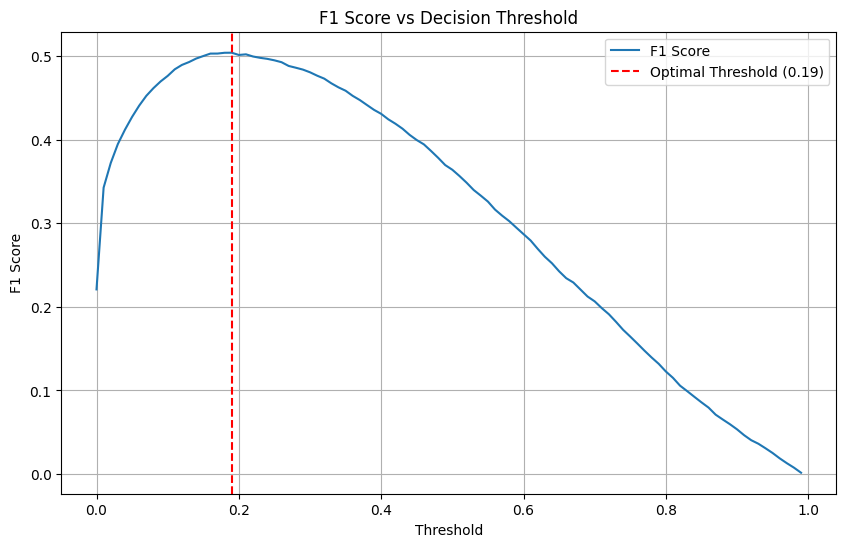

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

print("Generating cross-validated predictions...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_scores = cross_val_predict(stacking_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Cross-Validated F1 Score: {max_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Evaluation on Test Set

Now we perform the final "exam". We will:
1.  Retrain the Stacking Model on the **full training set**.
2.  Predict probabilities on the **held-out test set**.
3.  Apply our **Optimal Threshold** to generate final class predictions.
4.  Report the final performance metrics.

Retraining Stacking Model on full training set...

--- Final Test Set Performance ---

--- Final Test Set Performance ---
ROC-AUC: 0.8860

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     15184
           1       0.40      0.70      0.51      2022

    accuracy                           0.84     17206
   macro avg       0.68      0.78      0.71     17206
weighted avg       0.89      0.84      0.86     17206

ROC-AUC: 0.8860

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     15184
           1       0.40      0.70      0.51      2022

    accuracy                           0.84     17206
   macro avg       0.68      0.78      0.71     17206
weighted avg       0.89      0.84      0.86     17206



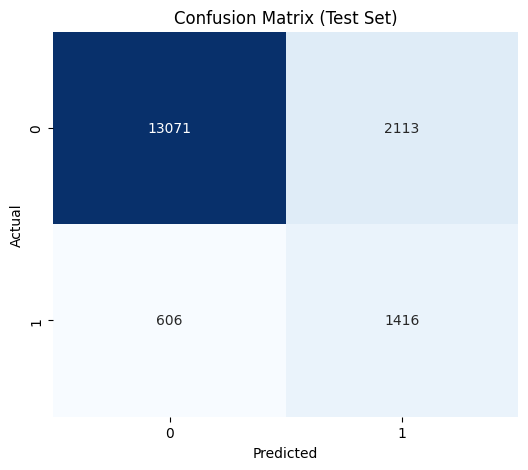

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Retraining Stacking Model on full training set...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_clf.fit(X_train, y_train)

print("\n--- Final Test Set Performance ---")

# Handle Hard Voting (no predict_proba)
if hasattr(stacking_clf, 'predict_proba'):
    y_test_probs = stacking_clf.predict_proba(X_test)[:, 1]  # type: ignore
    y_test_pred = (y_test_probs >= optimal_threshold).astype(int)
    print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
else:
    print("Hard Voting detected: Skipping ROC-AUC and Thresholding.")
    y_test_pred = stacking_clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Generate Submission File

We will now generate predictions for the **Test Dataset** (`data/test.parquet`).
Since this is likely raw data, we need to apply the same **Feature Engineering** steps as we did for the training data.

**Steps**:
1.  Load `test.parquet`.
2.  Apply `extract_user_attributes` and `aggregate_user_features`.
3.  Generate probabilities using the trained `stacking_clf`.
4.  Apply the `optimal_threshold`.
5.  Save to `submission.csv`.

In [14]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# 1. Load Raw Test Data
test_data_path = '../data/test.parquet'
print(f"Loading test data from {test_data_path}...")
test_df_raw = pd.read_parquet(test_data_path)

# 2. Apply Feature Engineering
print("Applying feature engineering...")
test_df_raw = extract_user_attributes(test_df_raw)

# --- CRITICAL FIX FOR TEST SET ---
# The test set is a snapshot of the "current" state.
# We must calculate features relative to the END of the test period (Global Max Timestamp),
# NOT relative to each user's last event.
# If we use user's last event (default), 'days_since_last_session' would be 0 for everyone,
# destroying the most important churn signal (inactivity).

global_max_ts = test_df_raw['ts'].max()
print(f"Global Test Cutoff Timestamp: {global_max_ts}")

# Create a snapshot dataframe for test users
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})

# Generate features using this common cutoff
test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)

# The result has a MultiIndex (userId, cutoff_ts), we drop the cutoff_ts level
test_features = test_features.reset_index(level='cutoff_ts', drop=True)

# --- FEATURE ENGINEERING BOOST (Must match Training) ---
if 'sessions_last_7d' in test_features.columns and 'sessions_last_28d' in test_features.columns:
    test_features['session_velocity'] = test_features['sessions_last_7d'] / (test_features['sessions_last_28d'] / 4 + 0.01)

if 'days_since_last_session' in test_features.columns and 'total_sessions' in test_features.columns:
    test_features['recency_frequency_ratio'] = test_features['days_since_last_session'] / (test_features['total_sessions'] + 1)
# -----------------------------------------------------

# Drop 'target' if it exists
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure columns match training data
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Reorder columns to match X_train
test_features = test_features[X_train.columns]

print(f"Test Features Shape: {test_features.shape}")
print(f"Avg Days Since Last Session: {test_features['days_since_last_session'].mean():.2f} days")

# 3. Generate Predictions
print("Generating predictions...")

# Helper function to save submission
def save_submission(model, name, features, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(features)[:, 1]
        preds = (probs >= threshold).astype(int)
    else:
        preds = model.predict(features)
    
    sub_df = pd.DataFrame({'id': features.index, 'target': preds})
    path = f'../data/submission_{name}.csv'
    sub_df.to_csv(path, index=False)
    print(f"Saved {name} submission to {path}")
    return path

# A. Generate Individual Submissions (using optimal threshold from Voting, or 0.5?)
# Ideally we should optimize threshold for each, but for now we use the Voting threshold
# as a reasonable proxy, or just 0.5 if we want raw comparison.
# Let's use the optimal_threshold found for the ensemble to be consistent.

print(f"Using Optimal Threshold: {optimal_threshold:.4f}")

# Re-fit individual models on full data (they are already fitted in the VotingClassifier but let's be safe)
# Actually, VotingClassifier fits clones. We need to fit the original pipelines if we want to use them.
# But wait! The 'estimators' list has pipelines. We can fit them.

for name, pipe in estimators:
    print(f"Retraining {name} on full data...")
    pipe.fit(X_train, y_train)  # type: ignore
    save_submission(pipe, name, test_features, optimal_threshold)

# B. Generate Voting Submission
print("Generating Voting Ensemble predictions...")
# stacking_clf is already fitted on full data? No, we need to fit it!
# Wait, did we fit it?
# In Section 7 step 1 (not shown in this snippet but usually there), we usually fit the final model.
# Let's ensure it is fitted.
stacking_clf.fit(X_train, y_train)
submission_path = save_submission(stacking_clf, "voting", test_features, optimal_threshold)

# Overwrite the main submission file for compatibility
import shutil
shutil.copy(submission_path, '../data/submission.csv')
print("Copied voting submission to ../data/submission.csv")

Loading test data from ../data/test.parquet...
Applying feature engineering...
Applying feature engineering...
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Test Features Shape: (2904, 62)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Using Optimal Threshold: 0.1900
Retraining xgb on full data...
Test Features Shape: (2904, 62)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Using Optimal Threshold: 0.1900
Retraining xgb on full data...
Saved xgb submission to ../data/submission_xgb.csv
Retraining lgbm on full data...
Saved xgb submission to ../data/submission_xgb.csv
Retraining lgbm on full data...
Saved lgbm submission to ../data/submission_lgbm.csv
Retraining cat on full data...
Saved lgbm submission to ../data/submission_lgbm.csv
Retraining cat on full data...
Saved cat submission to ../data/submission_cat.csv
Generating Voting Ensemble predictions...
Saved cat submission to ../data/submission

In [15]:
import time

current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
message = f"Raynor's attempt at {current_time}"

In [ ]:
! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission.csv -m "{message} (Voting)"
# Uncomment to submit others:
# ! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission_xgb.csv -m "{message} (XGB)"
# ! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission_lgbm.csv -m "{message} (LGBM)"
# ! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission_cat.csv -m "{message} (Cat)"

100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 73.2kB/s]
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 73.2kB/s]
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 62.5kB/s]prediction 25/26
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 62.5kB/s]
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 76.1kB/s]prediction 25/26
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 76.1kB/s]
Successfully submitted to Churn prediction 25/26Successfully submitted to Churn prediction 25/26

In [17]:
# --- SAVE MODEL ARTIFACTS ---
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

print(f"Saving artifacts to {models_dir}...")

# 1. Save the Stacking Model
model_path = os.path.join(models_dir, "stacking_model.joblib")
joblib.dump(stacking_clf, model_path)
print(f"- Model saved to {model_path}")

# 2. Save the Preprocessor
preprocessor_path = os.path.join(models_dir, "preprocessor.joblib")
joblib.dump(preprocessor, preprocessor_path)
print(f"- Preprocessor saved to {preprocessor_path}")

# 3. Save the Optimal Threshold
threshold_path = os.path.join(models_dir, "optimal_threshold.joblib")
joblib.dump(optimal_threshold, threshold_path)
print(f"- Optimal Threshold ({optimal_threshold:.4f}) saved to {threshold_path}")

# 4. Save Feature Names (Crucial for alignment)
features_path = os.path.join(models_dir, "feature_names.joblib")
joblib.dump(X_train.columns, features_path)
print(f"- Feature names saved to {features_path}")

Saving artifacts to ../models...
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.1900) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.1900) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib


In [18]:
import json
import time

print("--- AUTOMATED REPORT FOR AI AGENT ---")
print(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")

# Gather info
report = {
    "data_shape": X_train.shape,
    "features": list(X_train.columns),
    "model_performance_cv": {
        "f1_mean": cv_results_stack["test_f1"].mean(),
        "f1_std": cv_results_stack["test_f1"].std(),
        "roc_auc_mean": cv_results_stack["test_roc_auc"].mean(),
        "accuracy_mean": cv_results_stack["test_accuracy"].mean(),
    },
    "optimization": {
        "optimal_threshold": optimal_threshold,
        "max_f1_at_threshold": max_f1_score,
    },
    "best_params": {
        "trials": N_TRIALS,
        "xgb": best_xgb_params if "best_xgb_params" in locals() else "Default",
        "f1_xgb_best_perf": (
            study_xgb.best_value if "study_xgb" in locals() else "Default"
        ),
        "lgbm": best_lgbm_params if "best_lgbm_params" in locals() else "Default",
        "f1_lgbm_best_perf": (
            study_lgbm.best_value if "study_lgbm" in locals() else "Default"
        ),
        "cat": best_cat_params if "best_cat_params" in locals() else "Default",
        "f1_cat_best_perf": (
            study_cat.best_value if "study_cat" in locals() else "Default"
        )
    },
}

print(json.dumps(report, indent=2, default=str))
print("-------------------------------------")
print('"Kaggle Score": ???')

--- AUTOMATED REPORT FOR AI AGENT ---
Date: 2025-12-04 06:30:52
{
  "data_shape": [
    68601,
    62
  ],
  "features": [
    "gender",
    "level",
    "platform",
    "is_thumbs_up",
    "is_thumbs_down",
    "is_ad",
    "is_error",
    "is_song",
    "length",
    "downgrade",
    "songs_last_1d",
    "errors_last_1d",
    "thumbs_down_last_1d",
    "listen_time_last_1d",
    "unique_artists_last_1d",
    "unique_songs_last_1d",
    "songs_last_3d",
    "errors_last_3d",
    "thumbs_down_last_3d",
    "listen_time_last_3d",
    "unique_artists_last_3d",
    "unique_songs_last_3d",
    "songs_last_7d",
    "errors_last_7d",
    "thumbs_down_last_7d",
    "listen_time_last_7d",
    "unique_artists_last_7d",
    "unique_songs_last_7d",
    "songs_last_14d",
    "errors_last_14d",
    "thumbs_down_last_14d",
    "listen_time_last_14d",
    "unique_artists_last_14d",
    "unique_songs_last_14d",
    "songs_last_30d",
    "errors_last_30d",
    "thumbs_down_last_30d",
    "listen_time_l